In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import pandas as pd
import nltk
from tensorflow.keras import Input, regularizers, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Concatenate, Dropout, LSTM, GRU
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout, Concatenate, Reshape
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop, SGD, Adadelta
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import files

uploaded = files.upload()

Saving fasttext.pickle to fasttext.pickle


In [3]:
df = pd.read_pickle('fasttext.pickle')

In [5]:
df.head()

,Unnamed: 0,User review,Review date,Star review,Text length,Has media,Has answer,Written by bot
0,0,"[[-0.6852187, 0.5956516, 0.30101123, 0.1036427...",2024-10-09,5,54,0,0,0
1,1,"[[-0.5282001, 0.45545566, 0.23057127, 0.081870...",2024-10-09,5,195,0,0,0
2,2,"[[-0.53618586, 0.46867236, 0.2354427, 0.083549...",2024-10-09,5,17,0,0,0
3,3,"[[-0.93997616, 0.81199014, 0.408119, 0.1381899...",2024-10-09,5,33,0,0,0
4,4,"[[-0.7105151, 0.6156051, 0.3244957, 0.10463562...",2024-10-09,5,15,0,0,0


In [13]:
del df['Review date']

In [14]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

In [15]:
df.head()

,User review,Star review,Text length,Has media,Has answer,Written by bot
0,"[[-0.6852187, 0.5956516, 0.30101123, 0.1036427...",5,54,0,0,0
1,"[[-0.5282001, 0.45545566, 0.23057127, 0.081870...",5,195,0,0,0
2,"[[-0.53618586, 0.46867236, 0.2354427, 0.083549...",5,17,0,0,0
3,"[[-0.93997616, 0.81199014, 0.408119, 0.1381899...",5,33,0,0,0
4,"[[-0.7105151, 0.6156051, 0.3244957, 0.10463562...",5,15,0,0,0


In [16]:
df['Has media'] = df['Has media'].replace({'True': '1', 'False': '0'})
df['Has media'].value_counts()

,count
Has media,
0,1699
1,717


In [17]:
y = df['Written by bot']
X = df.drop(columns=['Written by bot']).values

In [18]:
y, X = df['Written by bot'], df.drop(columns=['Written by bot'])

Исходное распределение классов: Counter({0: 1663, 1: 753})


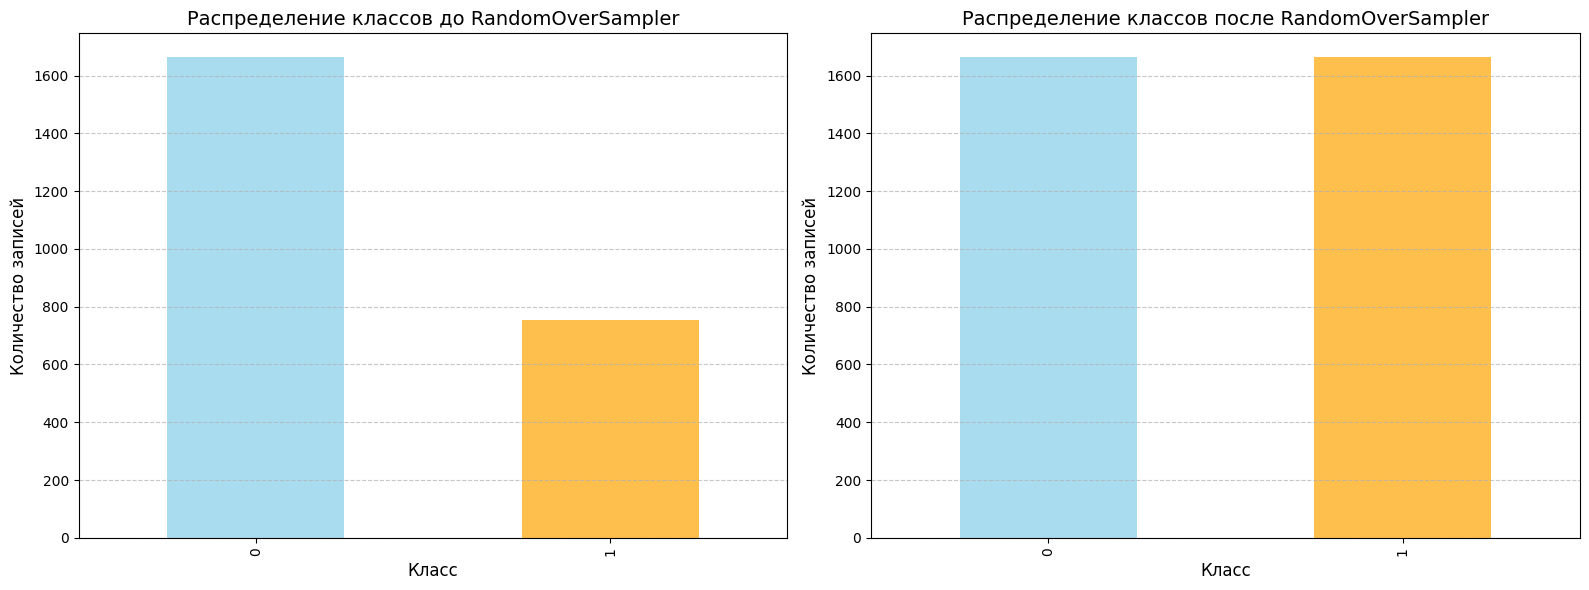

In [21]:
print("Исходное распределение классов:", Counter(y))

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

class_counts_before = y.value_counts()
class_counts_before.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7, ax=axes[0])
axes[0].set_title('Распределение классов до RandomOverSampler', fontsize=14)
axes[0].set_xlabel('Класс', fontsize=12)
axes[0].set_ylabel('Количество записей', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

class_counts_after = pd.Series(y_ros).value_counts()
class_counts_after.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7, ax=axes[1])
axes[1].set_title('Распределение классов после RandomOverSampler', fontsize=14)
axes[1].set_xlabel('Класс', fontsize=12)
axes[1].set_ylabel('Количество записей', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [23]:
import tensorflow as tf
# Создание DataFrame из данных
X_ros_df = pd.DataFrame(X_ros, columns=df.drop(columns=['Written by bot']).columns)

# Извлекаем текстовые представления (списки векторов FastText)
X_ros_text = X_ros_df['User review']

# Проверяем структуру данных перед преобразованием
print("Пример данных:", X_ros_text.iloc[0])
print("Тип данных:", type(X_ros_text.iloc[0]))

# Вариант 1: Усреднение векторов (если у тебя по вектору на слово)
X_ros_text_avg = np.array([np.mean(vectors, axis=0) if isinstance(vectors, (list, np.ndarray)) else np.zeros(300) for vectors in X_ros_text], dtype=np.float32)

# Вариант 2: Дополнение/усечение до фиксированной длины
X_ros_text_padded = tf.keras.preprocessing.sequence.pad_sequences(
    X_ros_text.tolist(), dtype='float32', maxlen=100, padding='post', truncating='post'
)

# Преобразуем числовые признаки в массив NumPy
X_ros_numeric = X_ros_df.drop(columns=['User review'])
X_ros_numeric = np.array(X_ros_numeric, dtype=np.float32)

# Проверяем размеры массивов
print("Shape of averaged text vectors:", X_ros_text_avg.shape)
print("Shape of padded text vectors:", X_ros_text_padded.shape)
print("Shape of numeric data:", X_ros_numeric.shape)

Пример данных: [array([-6.85218692e-01,  5.95651627e-01,  3.01011235e-01,  1.03642754e-01,
       -1.91587165e-01,  5.05881868e-02,  2.57220417e-01,  1.64898008e-01,
       -7.08583534e-01,  1.16248988e-02,  1.92301720e-01, -1.41853958e-01,
       -2.39993542e-01, -5.71122182e-05,  1.46036938e-01, -1.25962943e-01,
       -8.73678550e-02,  2.22352758e-01, -7.96468109e-02,  1.04780860e-01,
        1.37624238e-02, -4.62590979e-04, -3.14063519e-01,  7.47713149e-02,
        5.01872659e-01,  2.26058617e-01, -9.84026566e-02, -1.74730234e-02,
       -1.98644906e-01,  2.74070263e-01,  5.83171546e-01, -1.82740688e-01,
        2.07999721e-01, -1.55423552e-01, -1.78691968e-01,  4.06414941e-02,
       -1.05468631e-01, -2.93895900e-01, -2.10707471e-01, -1.74994439e-01,
       -4.57590878e-01, -3.92066211e-01, -2.43877634e-01,  1.59403652e-01,
       -2.93741703e-01, -1.39353529e-01,  6.31839782e-02,  7.90104270e-02,
       -2.82499850e-01,  3.03830147e-01, -9.64638591e-02,  2.24639744e-01,
        1

In [24]:
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_ros_text, X_ros_numeric, y_ros, test_size=0.2, random_state=42, stratify=y_ros
)

print(f"Размеры текстовых данных:")
print(f"X_train_text: {X_train_text.shape}, X_test_text: {X_test_text.shape}")
print(f"Размеры числовых данных:")
print(f"X_train_num: {X_train_num.shape}, X_test_num: {X_test_num.shape}")
print(f"Размеры меток:")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Размеры текстовых данных:
X_train_text: (2660,), X_test_text: (666,)
Размеры числовых данных:
X_train_num: (2660, 4), X_test_num: (666, 4)
Размеры меток:
y_train: (2660,), y_test: (666,)


In [26]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [28]:
import keras_tuner as kt
def build_model(hp):
    text_input = Input(shape=(384,), name='text_input')
    activation_choice = hp.Choice('activation', ['relu', 'swish', 'leaky_relu'])

    if activation_choice == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.1)
    else:
        activation = activation_choice

    x_text = Dense(hp.Int('dense_units', 16, 128, 16), activation=activation)(text_input)

    num_input = Input(shape=(7,), name='num_input')
    x_num = Dense(32, activation=activation)(num_input)

    combined = Concatenate()([x_text, x_num])
    x = combined

    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', 0.001, 0.1, 0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', 64, 256, 64), activation=activation, kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, 0.1))(x)

    output = Dense(2, activation='softmax')(x)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd', 'adadelta'])
    if optimizer_choice == 'adam':
        optimizer = Adam()
    elif optimizer_choice == 'adamw':
        optimizer = AdamW()
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_choice == 'adadelta':
        optimizer = Adadelta()
    else:
        optimizer = SGD()

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Настройка гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuner_dir',
    project_name='text_num_classification'
)

# Поиск лучших гиперпараметров
tuner.search(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]  # EarlyStopping при поиске
)

# Получение наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение лучшей модели
history = best_model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]  # EarlyStopping при обучении
)

# Оценка модели на тестовой выборке
test_loss, test_acc = best_model.evaluate([X_test_text, X_test_num], y_test)
print(f"Тестовая точность: {test_acc:.4f}")

# Сохранение обученной модели
best_model.save("best_model1.h5")

Trial 2 Complete [00h 00m 01s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 02s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
swish             |swish             |activation
16                |32                |dense_units
9                 |4                 |num_layers
l2                |l2                |reg_type_0
0.083             |0.04              |reg_value_0
256               |256               |units_0
0.5               |0.1               |dropout_0
adamw             |adam              |optimizer
l2                |l1                |reg_type_1
0.093             |0.001             |reg_value_1
64                |64                |units_1
0.1               |0.1               |dropout_1
l1                |l1                |reg_type_2
0.011             |0.001             |reg_value_2
64                |64                |units_2
0.2               |0.1               |dropout_2
l2                |l1                |reg_type_3
0

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ke

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/optree/ops.py", line 766, in tree_map
    return treespec.unflatten(map(func, *flat_args))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: Invalid dtype: object


In [35]:
import keras_tuner as kt
def build_model(hp):
    text_input = Input(shape=(384,), name='text_input')
    activation_choice = hp.Choice('activation', ['relu', 'swish', 'leaky_relu'])

    if activation_choice == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.1)
    else:
        activation = activation_choice

    x_text = Dense(hp.Int('dense_units', 16, 128, 16), activation=activation)(text_input)
    x_text = tf.keras.layers.Reshape((x_text.shape[-1], 1))(x_text)
    x_text = GRU(hp.Int('gru_units', 32, 256, 32), return_sequences=False)(x_text)

    num_input = Input(shape=(7,), name='num_input')
    x_num = Dense(32, activation=activation)(num_input)
    x_num = tf.keras.layers.Reshape((x_num.shape[-1], 1))(x_num)
    x_num = GlobalAveragePooling1D()(x_num)

    combined = Concatenate()([x_text, x_num])
    x = combined

    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', 0.001, 0.1, 0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', 64, 256, 64), activation=activation, kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, 0.1))(x)

    output = Dense(2, activation='softmax')(x)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd', 'adadelta'])
    if optimizer_choice == 'adam':
        optimizer = Adam()
    elif optimizer_choice == 'adamw':
        optimizer = AdamW()
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_choice == 'adadelta':
        optimizer = Adadelta()
    else:
        optimizer = SGD()

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Настройка гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuner_dir',
    project_name='text_num_classification'
)

# Поиск лучших гиперпараметров
tuner.search(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Получение наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение лучшей модели
history = best_model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Оценка модели на тестовой выборке
test_loss, test_acc = best_model.evaluate([X_test_text, X_test_num], y_test)
print(f"Тестовая точность: {test_acc:.4f}")

# Сохранение обученной модели
best_model.save("best_model_gru.h5")

Reloading Tuner from my_tuner_dir/text_num_classification/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
swish             |relu              |activation
16                |64                |dense_units
9                 |7                 |num_layers
l2                |l1                |reg_type_0
0.083             |0.007             |reg_value_0
256               |192               |units_0
0.5               |0.5               |dropout_0
adamw             |sgd               |optimizer
l2                |l2                |reg_type_1
0.093             |0.02              |reg_value_1
64                |128               |units_1
0.1               |0.1               |dropout_1
l1                |l2                |reg_type_2
0.011             |0.07              |reg_value_2
64                |64                |units_2
0.2               |0.3               |dropout_2
l2                |l1                |reg_type_3
0.013             |0.088  

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ke

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/optree/ops.py", line 766, in tree_map
    return treespec.unflatten(map(func, *flat_args))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: Invalid dtype: object


In [41]:
df['User review'] = df['User review'].apply(lambda x: np.array(x))

In [42]:
df.dtypes

,0
User review,object
Star review,int64
Text length,int64
Has media,object
Has answer,int64
Written by bot,int64
